# Отток клиентов банка

***Описание проекта:*** 

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры (не менее 0.59).

Дополнительно измерьте *AUC-ROC*, сравните её значение с *F1*-мерой.

Источник данных для проекта: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

***Описание данных:***

*Признаки*
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата


*Целевой признак*
- `Exited` — факт ухода клиента

***План работы над проектом:***

1. Подготовка данных;
2. Исследование задачи;
3. Борьба с дисбалансом;
4. Тестирование модели;
5. Общий вывод.

## Подготовка данных

In [1]:
# установим последнюю версию scikit-learn, если она не установлена
# теперь для OneHotEncoder работает одновремеено drop='first' и handle_unknown='ignore'
!pip install scikit-learn==1.1.3

In [2]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    roc_auc_score, 
    roc_curve,
    recall_score)

from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set(rc={'figure.figsize': (15, 20)})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9354,9355,15791501,Carroll,590,France,Male,43,8.0,0.00,2,1,1,143628.31,0
286,287,15573112,Kang,602,Spain,Male,29,NaN,103907.28,1,1,0,161229.84,0
2425,2426,15630167,Gibson,684,Spain,Female,39,4.0,139723.90,1,1,1,120612.11,0
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
7338,7339,15796111,Smith,708,Germany,Female,54,8.0,145151.40,1,0,1,125311.17,1


Количество пропусков в таблице:

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64 

Количество дубликатов в таблице: 0


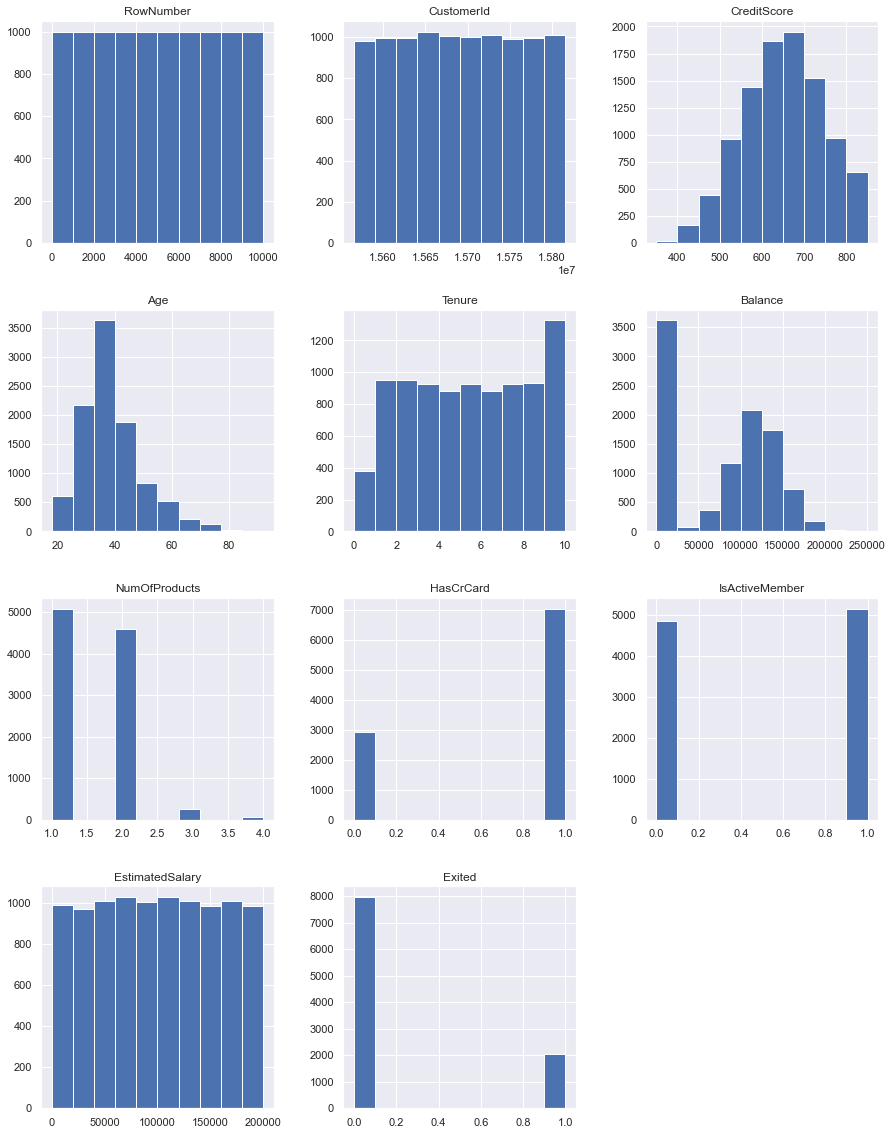

In [3]:
data = pd.read_csv('Churn.csv')
data.info()
display(data.sample(5))
print('Количество пропусков в таблице:\n')
print(data.isna().sum(), '\n')
print('Количество дубликатов в таблице:',  data.duplicated().sum())
data.hist(figsize=(15, 20));

Открыв датасет мы видим, что у нас есть пропуски в столбце `Tenure` (сколько лет человек является клиентом банка) - `909 штук`. На первывый взляд показалось, что система просто оставляет пустое значение в первый год обслуживания клиентов, однако по гистограмме стоблца мы видим `~400 человек` имеет значение `0`. Итого - мы не можем заменить пропуски средним значением и поставить 0 мы так же не можем поэтому удалим строки из таблицы, чтобы они не помешали обучению для нашей модели. Это примерно `9%` от общего объёма данных.

In [4]:
data = data.dropna(subset=['Tenure'])
print(data.isna().sum(), '\n')

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64 



Отлично. Далее мы переименнуем все названия столцов. Как минимум приведём всё к нижнему регистру и в некоторых используем `Snake case стиль`.

In [5]:
data.columns = map(str.lower, data.columns)
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

Далее мы удалим у таблицы не нужные для обучения столбцы, а конкретно `row_number, surname, customer_id`.

In [6]:
data = data.drop(['row_number', 'surname', 'customer_id'], axis=1).reset_index(drop=True)

Мы сделаем разбивку датасета на 3 части. На обучающую выборку - это будет `60%` данных. На валидную и тестовую мы отвели по `20% (3|1|1)`

In [7]:
features = data.drop(['exited'], axis=1)
target = data['exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=123456)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(5454, 10)
(1819, 10)
(1818, 10)


Далее закодируем категориальные признаки как однократный числовой массив. Используем `OneHotEncoder`.

In [8]:
# data_ohe = pd.get_dummies(data, drop_first=True)
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False).fit(features_train[ohe_features_ridge])

In [9]:
# кодируем признаки train
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features_ridge])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features_ridge, axis=1)

In [12]:
# кодируем признаки valid
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features_ridge])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_valid = features_valid.drop(ohe_features_ridge, axis=1)

In [14]:
# кодируем признаки test
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features_ridge])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_test = features_test.drop(ohe_features_ridge, axis=1)

In [16]:
features_test.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
1045,693,40,0.0,120711.73,1,0,0,27345.18,1.0,0.0,1.0
6487,529,46,8.0,0.00,1,0,0,126511.94,0.0,0.0,1.0
8093,718,32,9.0,169947.41,2,1,1,27979.16,1.0,0.0,1.0


Далее нам нужно стандартизировать данные. Обучим модель StandardScaler на features_train и прогоним через неё `2` другие части.

In [17]:
pd.options.mode.chained_assignment = None
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [19]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8483,0.809075,-1.039327,-1.025995,0.554904,-0.908179,1,0,0.019508,0.0,0.0,0.0
3431,-1.152518,-1.227561,0.696524,0.480609,-0.908179,0,0,0.056167,0.0,0.0,1.0
6770,-0.398853,0.090079,1.385532,-1.237830,-0.908179,1,1,0.848738,0.0,0.0,1.0
1350,-0.749875,-0.286389,0.352020,-1.237830,0.809300,1,1,-0.894953,0.0,0.0,1.0
4047,-1.028628,-0.756975,-0.336987,-1.237830,0.809300,0,1,-1.284516,0.0,0.0,1.0


***Вывод:*** Мы подготовили данные для обучения модели. Что именно мы сделали:
- удалили пропуски в столбце `Tenure` (сколько лет человек является клиентом банка) - `909 штук` (олоко `9%` от всех данных) так как нет возможности их восстановить
- мы переимменовали все названия столцов для удобства дальнейшего использования
- и удалили часть столбцов, которые не нужны для обучения модели, а именно `row_number, surname, customer_id`
- разбили датасет на `3 части`. На обучающую выборку - это будет `60%` данных. На валидную и тестовую мы отвели по `20% (3|1|1)`
- закодировали категориальные признаки как однократный числовой массив. Использовали `OneHotEncoder`
- стандартизаровали данные при помощи `StandardScaler`.

## Исследование задачи

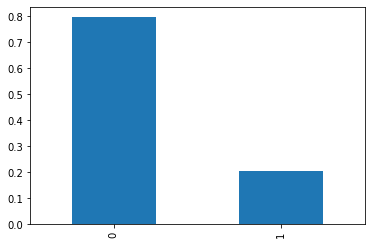

In [21]:
data['exited'].value_counts(normalize=True).plot(kind='bar');

Исследовав целевые значения мы обнаружили, что существует `заментый дисбаланс`. Положительный значений значительно меньше. Это значит, что в дальнейшем мы будем использовать инструменты для борьмы с дисбалансом. А для начала определимся какая модель будет лучше всего работать с нашим набором данных. 

Будем искать лучшую модель опираясь на значение `F1` метрики.

In [45]:
%%time
# начнём с модели LogisticRegression
model_lr = LogisticRegression(solver = 'liblinear', random_state=12345).fit(features_train, target_train)

predictions_valid = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

# характеристики модели на базе лучших гиперпараметров
print("F1:", f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_lr))

F1: 0.3096234309623431
recall модели: 0.20273972602739726
AUC-ROC модели: 0.7700382506453619
CPU times: user 22.9 ms, sys: 55.7 ms, total: 78.5 ms
Wall time: 21.6 ms


In [43]:
%%time
# далее модель DecisionTreeClassifier
best_model = None
best_result = 0
for depth in range(1, 16):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train, target_train)
    predictions_valid = model_dtc.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model_dtc
        best_result = result

print('F1 лучшей модели:', best_result)
print('Параметры лучшей модели:', best_model)

F1 лучшей модели: 0.5662251655629139
Параметры лучшей модели: DecisionTreeClassifier(max_depth=7, random_state=12345)
CPU times: user 262 ms, sys: 15.5 ms, total: 277 ms
Wall time: 278 ms


In [44]:
# характеристики модели на базе лучших гиперпараметров
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=7).fit(features_train, target_train)
predictions_valid = model_dtc.predict(features_valid)

probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

print('F1 модели:', f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_dtc))

F1 модели: 0.5662251655629139
recall модели: 0.4684931506849315
AUC-ROC модели: 0.8339629929716794


In [13]:
%%time
# модель RandomForestClassifier
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 201, 10):
    for depth in range (1, 16):
        model_rfc = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model_rfc.fit(features_train, target_train)
        predictions_valid = model_rfc.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model_rfc
            best_result = result
        
print('F1 лучшей модели:', best_result)
print('Параметры лучшей модели:', best_model)

F1 лучшей модели: 0.5668449197860962
Параметры лучшей модели: RandomForestClassifier(max_depth=14, n_estimators=40, random_state=12345)
CPU times: user 2min 27s, sys: 875 ms, total: 2min 28s
Wall time: 2min 28s


In [47]:
# характеристики модели на базе лучших гиперпараметров
model_rfc = RandomForestClassifier(max_depth=14, n_estimators=40, random_state=12345).fit(features_train, target_train)
predictions_valid = model_rfc.predict(features_valid)

probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

print('F1 модели:', f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_rfc))

F1 модели: 0.5668449197860962
recall модели: 0.43561643835616437
AUC-ROC модели: 0.8524316481694334


***Вывод:*** Мы обнаружили, что существует заментый дисбаланс. Положительных значений значительно меньше. При поиске оптаимальной модели лучшие показатели у модели `RandomForestClassifier`, где `F1=0.57` и `DecisionTreeClassifier` с таким же показателем, но значение `recall` у `DecisionTreeClassifier` больше. `0.47 к 0.44`, а вот с `AUC-ROC` моделей наоборот. У `RandomForestClassifier` больше. `0.85 к 0.83`.

## Борьба с дисбалансом

Для борьбы с дисбалансом используем 2 метода. В первом добавим положительный целевых значений. (1)

In [49]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Будем искать лучшие гиперпараметры моделей на базе новых данных.

In [50]:
%%time
# начнём опять с модели LogisticRegression
model_lr = LogisticRegression(solver = 'liblinear', random_state=12345).fit(features_upsampled, target_upsampled)

predictions_valid = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

# характеристики модели на базе лучших гиперпараметров
print("F1:", f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_lr))

F1: 0.48971962616822423
recall модели: 0.7178082191780822
AUC-ROC модели: 0.7715060956077707
CPU times: user 47.8 ms, sys: 36.1 ms, total: 83.9 ms
Wall time: 27.2 ms


In [52]:
%%time
# далее модель DecisionTreeClassifier
best_model = None
best_result = 0
for depth in range(1, 16):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_upsampled, target_upsampled)
    predictions_valid = model_dtc.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model_dtc
        best_result = result

print('F1 лучшей модели:', best_result)
print('Параметры лучшей модели:', best_model)

F1 лучшей модели: 0.5757575757575757
Параметры лучшей модели: DecisionTreeClassifier(max_depth=5, random_state=12345)
CPU times: user 331 ms, sys: 81 µs, total: 331 ms
Wall time: 330 ms


In [53]:
# характеристики модели на базе лучших гиперпараметров
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=5).fit(features_upsampled, target_upsampled)
predictions_valid = model_dtc.predict(features_valid)

probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

print('F1 модели:', f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_dtc))

F1 модели: 0.5757575757575757
recall модели: 0.7287671232876712
AUC-ROC модели: 0.8426494695784892


In [54]:
%%time
# модель RandomForestClassifier
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 201, 10):
    for depth in range (1, 16):
        model_rfc = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model_rfc.fit(features_upsampled, target_upsampled)
        predictions_valid = model_rfc.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model_rfc
            best_result = result
        
print('F1 лучшей модели:', best_result)
print('Параметры лучшей модели:', best_model)

F1 лучшей модели: 0.6264044943820225
Параметры лучшей модели: RandomForestClassifier(max_depth=14, n_estimators=70, random_state=12345)
CPU times: user 3min 4s, sys: 2.22 s, total: 3min 7s
Wall time: 3min 7s


In [56]:
# характеристики модели на базе лучших гиперпараметров
model_rfc = RandomForestClassifier(max_depth=14, n_estimators=70, random_state=12345).fit(features_upsampled, target_upsampled)
predictions_valid = model_rfc.predict(features_valid)

probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

print('F1 модели:', f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_rfc))

F1 модели: 0.6264044943820225
recall модели: 0.6109589041095891
AUC-ROC модели: 0.8569407020783479


Во-втором варианте борьбы с дисбалансом `уберём часть отрицательных` целевых значений. (0)

In [57]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

Так же найдём лучшие гиперпараметры моделей на базе новых данных.

In [59]:
%%time
# начнём опять с модели LogisticRegression
model_lr = LogisticRegression(solver = 'liblinear', random_state=12345).fit(features_downsampled, target_downsampled)

predictions_valid = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

# характеристики модели на базе лучших гиперпараметров
print("F1:", f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_lr))

F1: 0.45400593471810097
recall модели: 0.4191780821917808
AUC-ROC модели: 0.769214825422547
CPU times: user 17.6 ms, sys: 56 ms, total: 73.6 ms
Wall time: 18.1 ms


In [60]:
%%time
# далее модель DecisionTreeClassifier
best_model = None
best_result = 0
for depth in range(1, 16):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_downsampled, target_downsampled)
    predictions_valid = model_dtc.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model_dtc
        best_result = result

print('F1 лучшей модели:', best_result)
print('Параметры лучшей модели:', best_model)

F1 лучшей модели: 0.5894428152492668
Параметры лучшей модели: DecisionTreeClassifier(max_depth=6, random_state=12345)
CPU times: user 186 ms, sys: 38 µs, total: 186 ms
Wall time: 184 ms


In [63]:
# характеристики модели на базе лучших гиперпараметров
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=6).fit(features_downsampled, target_downsampled)
predictions_valid = model_dtc.predict(features_valid)

probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

print('F1 модели:', f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_dtc))

F1 модели: 0.5894428152492668
recall модели: 0.5506849315068493
AUC-ROC модели: 0.8323717284392607


In [62]:
%%time
# модель RandomForestClassifier
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 201, 10):
    for depth in range (1, 16):
        model_rfc = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model_rfc.fit(features_downsampled, target_downsampled)
        predictions_valid = model_rfc.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model_rfc
            best_result = result
        
print('F1 лучшей модели:', best_result)
print('Параметры лучшей модели:', best_model)

F1 лучшей модели: 0.638109305760709
Параметры лучшей модели: RandomForestClassifier(max_depth=9, n_estimators=110, random_state=12345)
CPU times: user 1min 42s, sys: 1.54 s, total: 1min 43s
Wall time: 1min 43s


In [64]:
# характеристики модели на базе лучших гиперпараметров
model_rfc = RandomForestClassifier(max_depth=9, n_estimators=110, random_state=12345).fit(features_downsampled, target_downsampled)
predictions_valid = model_rfc.predict(features_valid)

probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

print('F1 модели:', f1_score(target_valid, predictions_valid))
print('recall модели:', recall_score(target_valid, predictions_valid))
print('AUC-ROC модели:', roc_auc_score(target_valid, probabilities_one_valid_rfc))

F1 модели: 0.638109305760709
recall модели: 0.5917808219178082
AUC-ROC модели: 0.8645983682237004


***Вывод:*** Мы сбалансировали модель `2` разными способами. Лучший результат показал вариант с уменьшением отрицательных целевых значений (`downsample`)
А лучшая модель `RandomForestClassifier` со значениями 
- `F1=0.64`
- `recall=0.59`
- `AUC-ROC=0.86`

## Тестирование модели

F1 модели RandomForestClassifier на тестовой выборке: 0.6323319027181689
AUC-ROC модели RandomForestClassifier на тестовой выборке: 0.8653848702583473


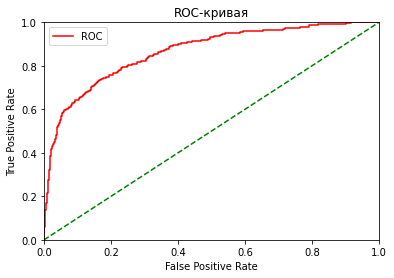

In [65]:
# проверим модель на тестовой выборке используя лучшие настройки
predictions_test = model_rfc.predict(features_test)
print("F1 модели RandomForestClassifier на тестовой выборке:", f1_score(target_test, predictions_test))

probabilities_valid_rfc = model_rfc.predict_proba(features_test)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]
print("AUC-ROC модели RandomForestClassifier на тестовой выборке:", roc_auc_score(target_test, probabilities_one_valid_rfc))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

fper, tper, thresholds = roc_curve(target_test, probabilities_one_valid_rfc)
plot_roc_curve(fper, tper)

Что касается одекватности модели, то проверим её по метрике `AUC-ROC` у константной модели.

In [19]:
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

print('AUC-ROC константой модели:', roc_auc_score(target_test, target_predict_constant))

AUC-ROC константой модели: 0.5


***Вывод:*** У нас получилась модель со значением `F1=0.63` на тестовой выборке. Что касается адекватности, то `AUC-ROC` константой модели - `0.5`, а у нашей лучшей модели `AUC-ROC - 0.87`. Адекватность доказана.

## Итоговый вывод

В начале исследования мы подготовили данные для обучения модели:
- удалили пропуски в столбце `Tenure` (сколько лет человек является клиентом банка) - `909 штук` (олоко `9%` от всех данных) так как нет возможности их восстановить
- мы переимменовали все названия столцов для удобства дальнейшего использования
- и удалили часть столбцов, которые не нужны для обучения модели, а именно `row_number, surname, customer_id`
- закодировали категориальные признаки как однократный числовой массив. Использовали метод OneHotEncoder
- разбили датасет на `3` части. На обучающую выборку - это будет `60%` данных. На валидную и тестовую мы отвели по `20% (3|1|1)`
- стандартизаровали данные при помощи `StandardScaler`.

При поиске оптимальной модели мы обнаружили:
Что существует заментый дисбаланс. Положительных значений значительно меньше. Лучшие показатели F1 у моделей `RandomForestClassifier`, где `F1=0.57` и `DecisionTreeClassifier` с таким же показателем, но значение `recall` у `DecisionTreeClassifier` больше. `0.47 к 0.44`, а вот с `AUC-ROC` моделей наоборот. У `RandomForestClassifier` больше. `0.85 к 0.83`.

Мы сбалансировали модель `2` разными способами. Лучший результат показал вариант с уменьшением отрицательных целевых значений (`downsample`). А модель `RandomForestClassifier` со значением `F1=0.64 и AUC-ROC= 0.86` получилась лучше остальных. Показатель recall у неё `0.59`. На тестовой выборке она сохранила показатели метрики. Что касается адекватности, то `AUC-ROC` константой модели - `0.5`, а у нашей лучшей модели `AUC-ROC - 0.87`. Адекватность доказана.